In [3]:
import glob, scipy
import cv2, imageio
import numpy as np

from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
image_paths = glob.glob('retina2/*.bmp')
images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]

H, W = images[0].shape
print(f'Image shape: height={H}, width={W}')

FILENAME_OFFSET = int(image_paths[0][-7:-4])
print(f'Filename offset: {FILENAME_OFFSET}')

Image shape: height=349, width=350
Filename offset: 172


In [5]:
with imageio.get_writer('viz_outputs/retina2.gif', mode='I', fps=30) as writer:
    for i, image in enumerate(images):
        image_copy = image.copy()
        cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        writer.append_data(image)

### Temporal averaging experiment

Text(0.5, 1.0, 'Temporal averaged image')

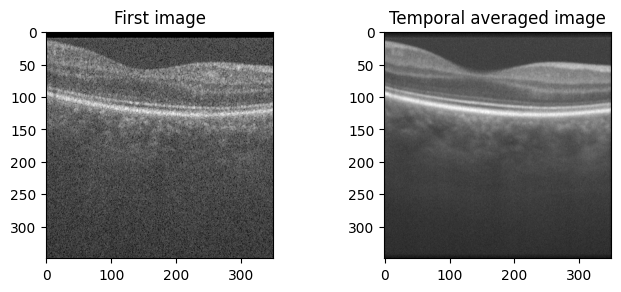

In [6]:
OFFSET, N = 0, 30

first_image = scipy.ndimage.shift(images[OFFSET], (10, 0))
# first_image = cv2.resize(first_image, (0, 0), fx=10, fy=10)
corrected_images = [first_image]

for i in range(OFFSET+1, OFFSET+N):
    offset_image = images[i]
    # offset_image = cv2.resize(offset_image, (0, 0), fx=10, fy=10)
    shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1)
    corrected_image = scipy.ndimage.shift(offset_image, shift)
    corrected_images.append(corrected_image)

with imageio.get_writer('viz_outputs/retina2_shifted.gif', mode='I', fps=10) as writer:
    for i, image in enumerate(corrected_images):
        image_copy = image.copy()
        cv2.putText(image_copy, f'Image {FILENAME_OFFSET+OFFSET+i}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(image_copy, f'Image {FILENAME_OFFSET+OFFSET+i}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        writer.append_data(image_copy)

temporal_averaged_image = np.mean(corrected_images, axis=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=100)
ax1.imshow(first_image, cmap='gray')
ax1.set_title('First image')
ax2.imshow(temporal_averaged_image, cmap='gray')
ax2.set_title('Temporal averaged image')

In [12]:
def temporal_averaging(images, offset, n):
    assert offset+n < len(images)
    first_image = images[offset]
    corrected_images = []
    for i in range(offset, offset+n):
        offset_image = images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=100, overlap_ratio=0.9)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)
    temporal_averaged_image = np.mean(corrected_images, axis=0)
    return temporal_averaged_image

Nwindow = 30
averaged_images = []

with imageio.get_writer(f'viz_outputs/retina2_corrected_Nwindow_{Nwindow}.gif', mode='I', fps=30) as writer:
    for i in tqdm(range(len(images)-Nwindow), desc=f'Temporal averaging for Nwindow={Nwindow}'):
        temporal_averaged_image = temporal_averaging(images, i, Nwindow)
        averaged_images.append(temporal_averaged_image)
        image_copy = temporal_averaged_image.copy().astype(np.uint8)
        cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}:{i+Nwindow+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}:{i+Nwindow+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        writer.append_data(image_copy)

Temporal averaging for Nwindow=30: 100%|██████████| 199/199 [07:05<00:00,  2.14s/it]


In [19]:
Nwindow = 30
first_image = averaged_images[0]

with imageio.get_writer(f'viz_outputs/retina2_corrected_Nwindow_{Nwindow}.gif', mode='I', fps=10) as writer:

    for i in tqdm(range(len(averaged_images)), desc=f'Temporal averaging for Nwindow={Nwindow}'):
    
        offset_image = averaged_images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1)
        corrected_image = scipy.ndimage.shift(offset_image, shift).astype(np.uint8)

        cv2.putText(corrected_image, f'Image {i-Nwindow+FILENAME_OFFSET}-{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(corrected_image, f'Image {i-Nwindow+FILENAME_OFFSET}-{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)
        writer.append_data(corrected_image)

Temporal averaging for Nwindow=30: 100%|██████████| 199/199 [00:13<00:00, 14.46it/s]


In [14]:
for Nwindow in range(5, 60, 5)[:1]:
    
    first_image = scipy.ndimage.shift(images[0], (10, 0))
    corrected_images = [first_image]

    for i in range(Nwindow-1):
        offset_image = images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1, overlap_ratio=0.1)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)

    with imageio.get_writer(f'viz_outputs/retina2_corrected_Nwindow_{Nwindow}.gif', mode='I', fps=30) as writer:

        for i in tqdm(range(Nwindow, len(images)), desc=f'Temporal averaging for Nwindow={Nwindow}'):
            
            corrected_images.pop(0)
            offset_image = images[i]
            shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1)
            corrected_image = scipy.ndimage.shift(offset_image, shift)
            corrected_images.append(corrected_image)

            tavg_image = np.mean(corrected_images, axis=0).astype(np.uint8)
            cv2.putText(tavg_image, f'Image {i-Nwindow+FILENAME_OFFSET}:{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.putText(tavg_image, f'Image {i-Nwindow+FILENAME_OFFSET}:{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
            writer.append_data(tavg_image)

Temporal averaging for Nwindow=5: 100%|██████████| 224/224 [00:16<00:00, 13.32it/s]


In [22]:
cv2.imwrite('viz_outputs/sample_172_201_Nwindow30.bmp', averaged_images[0])

True